# Tools developed for the MIGEM project
MIGEM is an approach to quantify gene expression in cells. The lab side was developed by Ryan McComb and Jacob Cooper. Jacob and I worked on various analytical tasks. These are two pieces of the analysis process that I worked out. The project was discontinued before a full analytical pipeline was developed.<br><br>
MIGEM quantifies gene expression by fluorescently labeling different the RNA molecules from different genes with a fluorescent barcode. Each unit of the barcode is detected in a different imaging channel, with each barcode yielding a unique RNA. This requires several rounds of staining and imaging, followed by restaining. The only constant marker from round-to-round is Hoechst staining of nuclei. During each successive round of imaging, the plates are aligned slightly differently in the microscope.<br>
One task is to perform automatic image alignment so that images from different rounds can be compared so that individual fluorescent spots can be aligned to get the barcodes for the different RNAs. I will show this first.<br>
Another task is to identify individual fluorescent spots that mark the labeled RNAs. I will show this second.

## To execute the cells in this notebook you'll need access to images:
please connect to /172.16.2.31/i_bio and paste the path into 'path_to_i_bio' below

In [1]:
path_to_i_bio = '/Volumes/i_bio/'

In [2]:
# example
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template
import os

%matplotlib inline

In [3]:
image_path = path_to_i_bio+'overexpression/temp/190507-MIGEM-example-images/'

In [4]:
print('path to images:', os.path.exists(image_path))

path to images: True


### This is the toolkit that I developed for MIGEM. It's included in the repo.

In [5]:
import Migem_translation as mg

## Image alignment in MIGEM
we'll load some sample images below

In [6]:
imfiles = ['190507 MiGEM 60x oil iterate_J19_s4_w189EA2F24-BE13-45D9-9B8B-40B0CFD9596E.tif',
           '190507 MiGEM 60x oil iterate-5-6_J19_s4_w1EDC4AAA5-8CCB-4B52-AE81-D553003D6D79.tif',
           '190507 MiGEM 60x oil iterate-7-8_J19_s4_w11A706174-80CE-46E7-8DBC-300CD616F4D7.tif',
           '190507 MiGEM 60x oil iterate_J19_s4_w253971359-9E54-40CF-B54F-6F8D2A0F9A43.tif',
           '190507 MiGEM 60x oil iterate-5-6_J19_s4_w21561A4D5-FDD4-4E00-8A4D-9B4CAAF4ED71.tif',
          ]

image_series = []
for file in imfiles:
    image = plt.imread(image_path+file)
    image_series.append(image)

fish_stack = mg.MakeZStack(image_series)

In [7]:
# Retreive the hoechst images
img1 = fish_stack[:,:,0]
img2 = fish_stack[:,:,1]
img3 = fish_stack[:,:,2]

## Show an overlay of 2 of the hoechst images
It seems apparent that they are of the same area of a well, but they are slightly misaligned

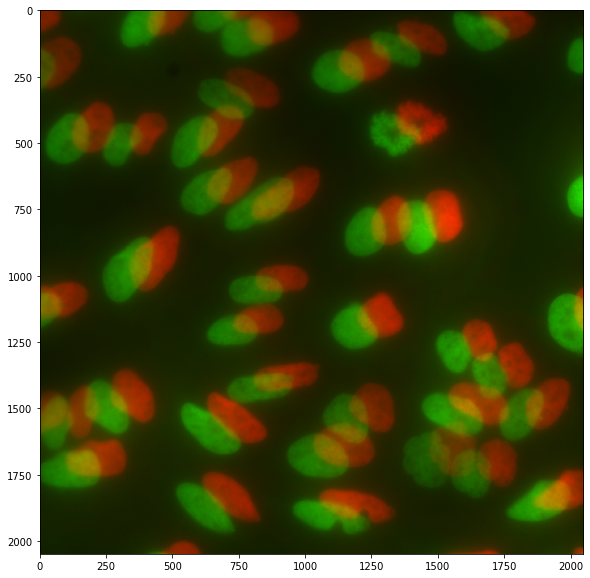

In [8]:
# Images taken in different runs are slightly misaligned
mg.RGBOverlay(img1,img2)

## Quantify the misalginment
I use the root mean squared difference of the per-pixel intensity to determine how aligned (or misaligned) the images are. The lower the RMS then the better the per-pixel intensity match between two images. This is useful for determining the quality of different alignment methods

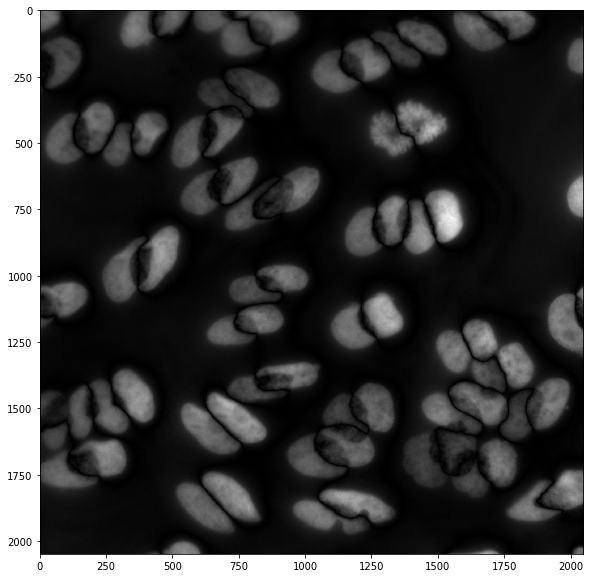

RMS difference of normalized images: 8915.00544433974
RMS difference of raw images: 8306.981649026346


In [9]:
# The function ImageDelta finds the per-pixel intensity difference between images and quantifies it.
RMS_ori_norm, RMS_ori_raw, im_ori_contrast = mg.ImageDelta(img1, img2)

plt.figure(figsize = [10,10])
plt.imshow(im_ori_contrast, cmap = 'gray', interpolation = 'none')
plt.show()
print ('RMS difference of normalized images:',RMS_ori_norm)
print ('RMS difference of raw images:',RMS_ori_raw)

# Use 2 different basic models to align images
First a look at the unaligned images

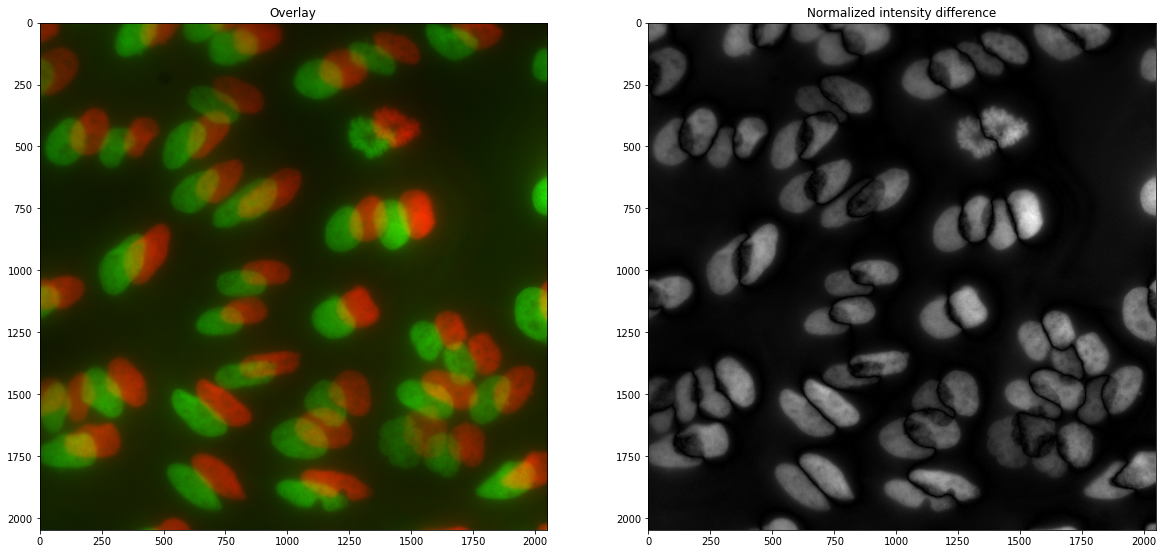

RMS difference of normalized images: 8915.00544433974
RMS difference of raw images: 8306.981649026346


In [10]:
# First consider the unaligned images
RMS_ori_norm, RMS_ori_raw = mg.PostRegistration(img1, img2)

#### Now use simple X,Y translation to align the images. Refine alignment to nearest pixel.
This runs on **skimage.feature.register_translation**<br>
Time these

In [11]:
import timeit

time = 0.8054134470876306


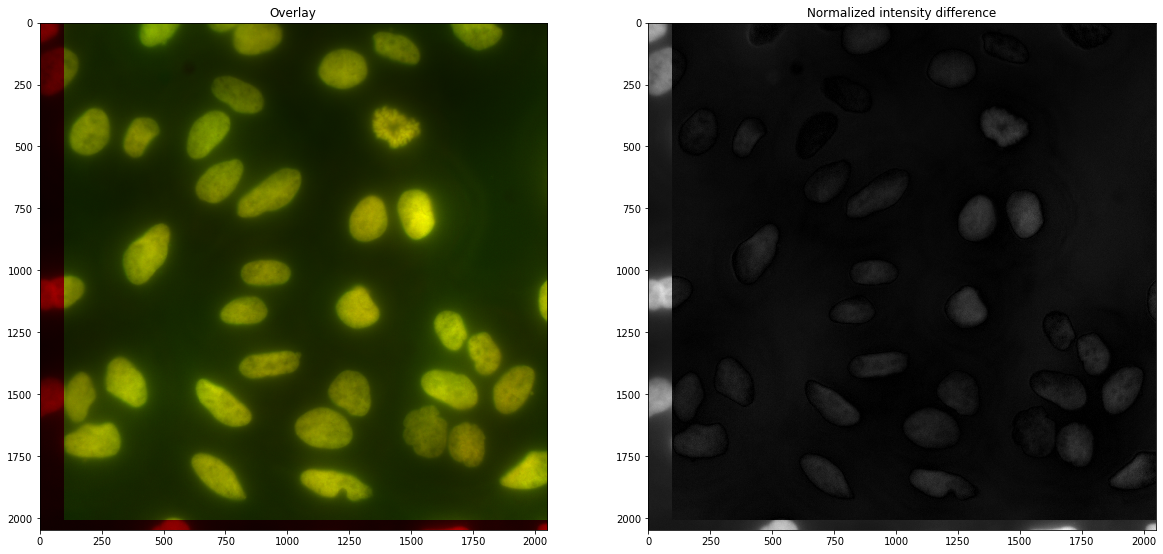

RMS difference of normalized images: 2225.5050886011986
RMS difference of raw images: 3243.1141283807247
translation (x,y): [97.0, -41.0] pixels


In [12]:
# Now a pixel precision translation model
start_time = timeit.default_timer()
img2_trans_lo_model, lo_trans = mg.GetTranslationModel(img1, img2,1)
tim1 = timeit.default_timer() - start_time
print ('time =', tim1)

RMS_tl_norm, RMS_tl_raw = mg.PostRegistration(img1, img2, img2_trans_lo_model)
print('translation (x,y):',lo_trans,'pixels')

#### Now use the same transliation model at a sub-pixel level

time = 0.692400592030026


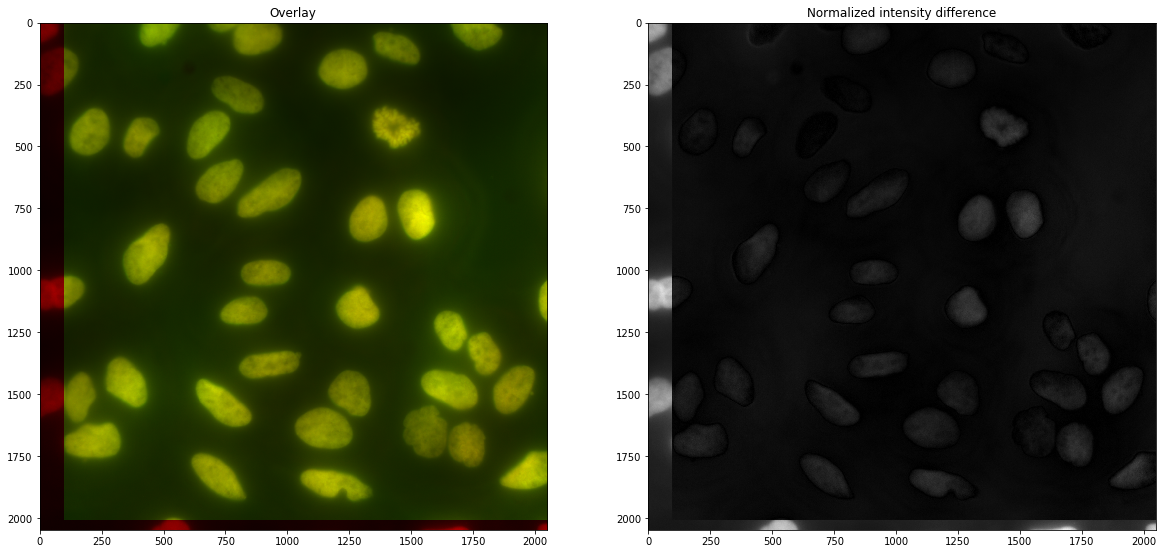

RMS difference of normalized images: 2223.8830687297414
RMS difference of raw images: 3239.37545813778
translation (x,y): [97.3, -40.7] pixels


In [13]:
# sub-pixel precision translation model
start_time = timeit.default_timer()
img2_trans_hi_model, hi_trans = mg.GetTranslationModel(img1, img2, 10)
tim2 = timeit.default_timer() - start_time
print ('time =', tim2)

RMS_th_norm, RMS_th_raw = mg.PostRegistration(img1, img2, img2_trans_hi_model)
print('translation (x,y):',hi_trans,'pixels')

The sub-pixel alignment is maybe a hair better. Noted.
#### Now try a RANSAC model that incorporates potential warping and rotation of the image
This runs on **skimage.measure.ransac**

time = 12.540296125924215


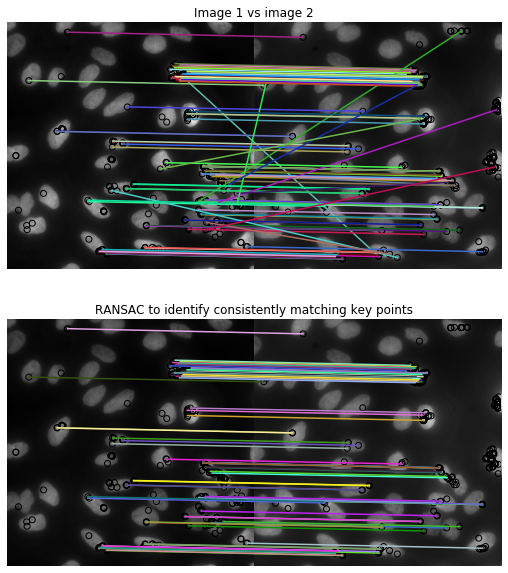

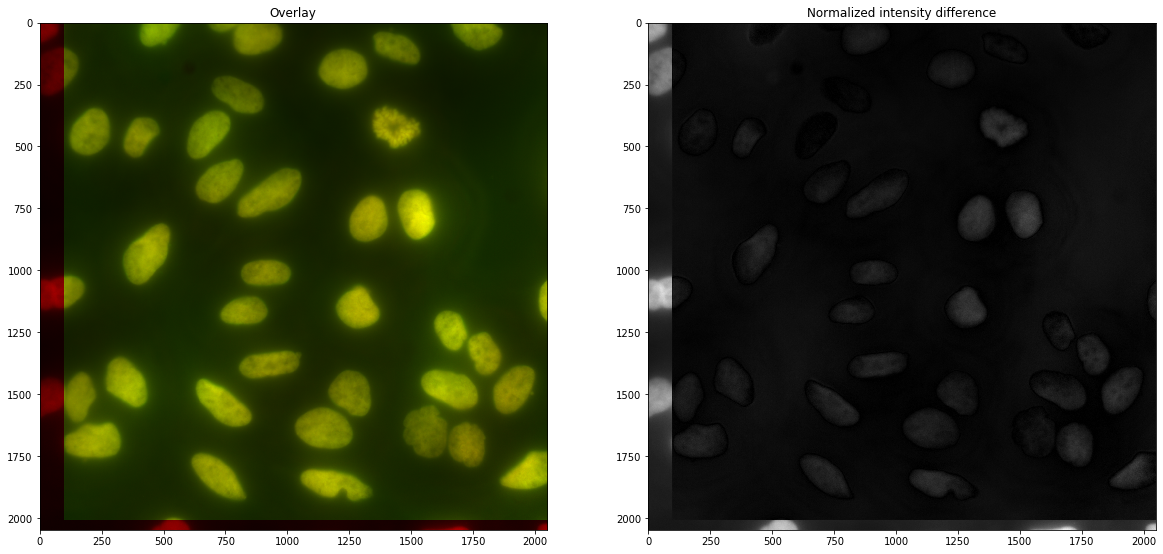

RMS difference of normalized images: 2224.083077237127
RMS difference of raw images: 3238.0706492262716
translation (x,y): [ 98.00619467 -41.82236925] pixels
rotation: 0.00020241890175500172 radians


In [14]:
# model that includes image warping -produces some visual output to show what's going on
# This first version does not show the image, but is fair for timing
start_time = timeit.default_timer()
img2_warp_model,warp_trans, warp_rotation = mg.GetWarpModel(img1, img2)
tim3 = timeit.default_timer() - start_time
print ('time =', tim3)

# this shows the ransac model
img2_warp_model,warp_trans, warp_rotation = mg.GetWarpModelOpen(img1, img2)

RMS_warp_norm, RMS_warp_raw = mg.PostRegistration(img1, img2, img2_warp_model)
print ('translation (x,y):',warp_trans,'pixels')
print ('rotation:',warp_rotation,'radians')

#### Compare the alignment models

In [15]:
print('image 1 vs image 2 data:\nmodel\t\t\t RMS normalized\t\t RMS raw\t\ttime\nunregistered images\t',
      RMS_ori_norm, '\t',RMS_ori_raw,'\nlow res translation','\t',
      RMS_tl_norm,'\t', RMS_tl_raw,'\t',tim1,'\nhi res translation','\t',RMS_th_norm, '\t',
      RMS_th_raw,'\t',tim2,'\nwarping model','\t\t',RMS_warp_norm,'\t', RMS_warp_raw,'\t',tim3)

image 1 vs image 2 data:
model			 RMS normalized		 RMS raw		time
unregistered images	 8915.00544433974 	 8306.981649026346 
low res translation 	 2225.5050886011986 	 3243.1141283807247 	 0.8054134470876306 
hi res translation 	 2223.8830687297414 	 3239.37545813778 	 0.692400592030026 
warping model 		 2224.083077237127 	 3238.0706492262716 	 12.540296125924215


#### It looks like RANSAC is fractionally better
However it takes a lot longer to execute. Keep this in mind as we move forward

### Compare alignment of the same cells, but taken at a different pairing of times

In [16]:
img3_trans_lo_model, lo3_trans = mg.GetTranslationModel(img1, img3,1)
img3_trans_hi_model, hi3_trans = mg.GetTranslationModel(img1, img3, 10)
img3_warp_model,warp3_trans, warp3_rotate = mg.GetWarpModel(img1, img3)

img3_trans_lo = mg.RegisterImage(img3, img3_trans_lo_model)
img3_trans_hi = mg.RegisterImage(img3, img3_trans_hi_model)
img3_warp = mg.RegisterImage(img3, img3_warp_model)

RMS_ori3_norm, RMS_ori3_raw, im_ori_contrast = mg.ImageDelta(img1, img3)
RMS_tl3_norm, RMS_tl3_raw, im_ori_contrast = mg.ImageDelta(img1, img3_trans_lo, img3_trans_lo.mask)
RMS_th3_norm, RMS_th3_raw, im_ori_contrast = mg.ImageDelta(img1, img3_trans_hi, img3_trans_hi.mask)
RMS_warp3_norm, RMS_warp3_raw, im_ori_contrast = mg.ImageDelta(img1, img3_warp, img3_warp.mask)

In [17]:
print('image 1 vs image 3 data:\nmodel\t\t\t RMS normalized\t\t RMS raw\nunregistered images\t',
      RMS_ori3_norm, '\t',RMS_ori3_raw,'\nlow res translation','\t',
      RMS_tl3_norm,'\t', RMS_tl3_raw,'\nhi res translation','\t',RMS_th3_norm, '\t',
      RMS_th3_raw,'\nwarping model','\t\t',RMS_warp3_norm,'\t', RMS_warp3_raw)

image 1 vs image 3 data:
model			 RMS normalized		 RMS raw
unregistered images	 9846.881749167183 	 9588.724350504459 
low res translation 	 2755.228103396612 	 3905.32949658473 
hi res translation 	 2757.053162691963 	 3903.0314932285323 
warping model 		 2754.0926557009097 	 3896.9096469749857


#### Again, RANSAC is fractionally better, but translation gets us almost all the way there
### Look at the alignments

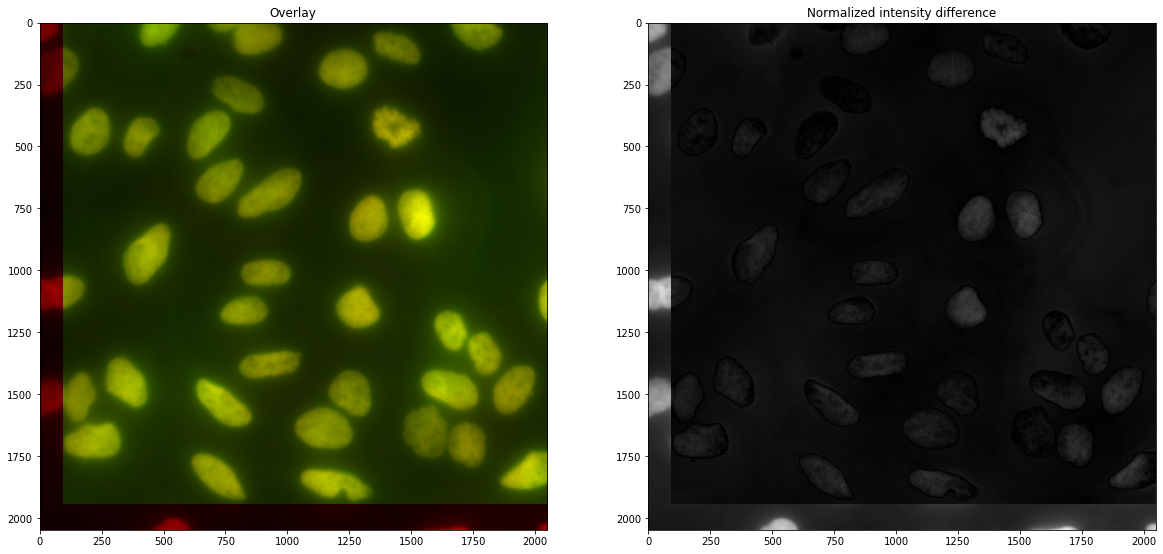

RMS difference of normalized images: 2367.811312733009
RMS difference of raw images: 3896.9096469749857


In [18]:
RMS_warp3_norm, RMS_warp3_raw = mg.PostRegistration(img1, img3, img3_warp_model)

In [19]:
img2_trans_hi_model, hi_trans = mg.GetTranslationModel(img1, img2, 10)
thing1 = mg.RegisterImage(img2, img2_trans_hi_model)
thing2 = mg.RegisterImage(img2, img2_trans_hi_model, out_mask = False)

In [20]:
thing2.shape

(2048, 2048)

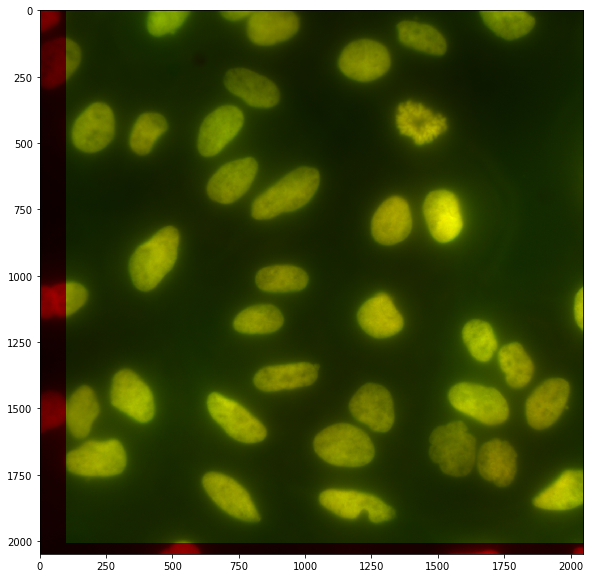

In [21]:
mg.RGBOverlay(img1, thing1)

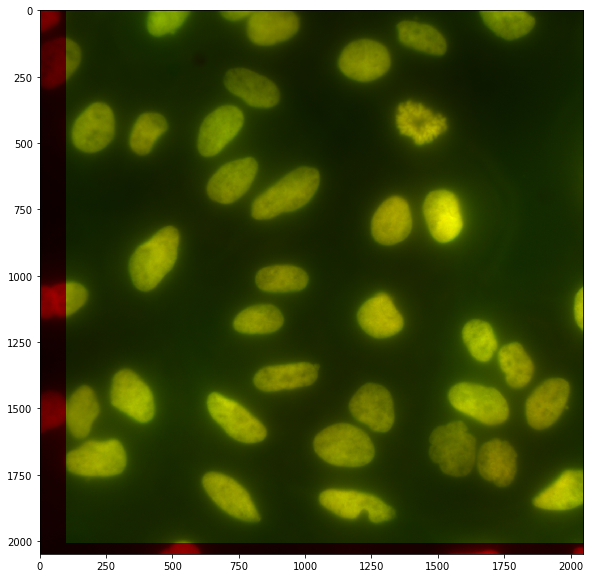

In [22]:
mg.RGBOverlay(img1, thing2)

### That's the basic image alignment toolkit that I built for MIGEM.
Local spot alignment would need some further refinement, but the project was discontinued before that work was complete. Below is work that I did to identify the fluorescent spots that mark individual RNA molecules

# Now for spot identification.
If we're going to identify an RNA based on a barcode, we'll need to identify fluorescent RNA spots.
### Pick a sample image to work with

In [23]:
sample_img = np.load(image_path+'sample_MIGEM_img.npy')

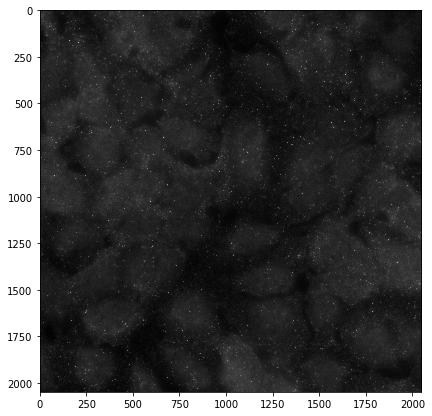

In [24]:
plt.figure(figsize = (6,6))
plt.imshow(sample_img, cmap = 'gray')
plt.tight_layout()
plt.show()

### Zoom in so we can see the individual spots

In [25]:
sample_500 = sample_img[0:500, 0:500]

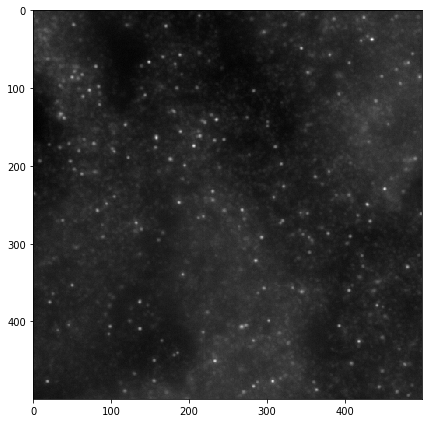

In [26]:
plt.figure(figsize = (6,6))
plt.imshow(sample_500, cmap = 'gray')
plt.tight_layout()
plt.show()

# Identify some spots to build the template
This is an interactive section of the notebook. You can run it, but doing so requires some manual intput to get the orientation of the spots correct to build the template. We'll load a template spot later, so it won't create any difficulties for the analysis.

### If you run this, click on the image to get the individual spots

<IPython.core.display.Javascript object>


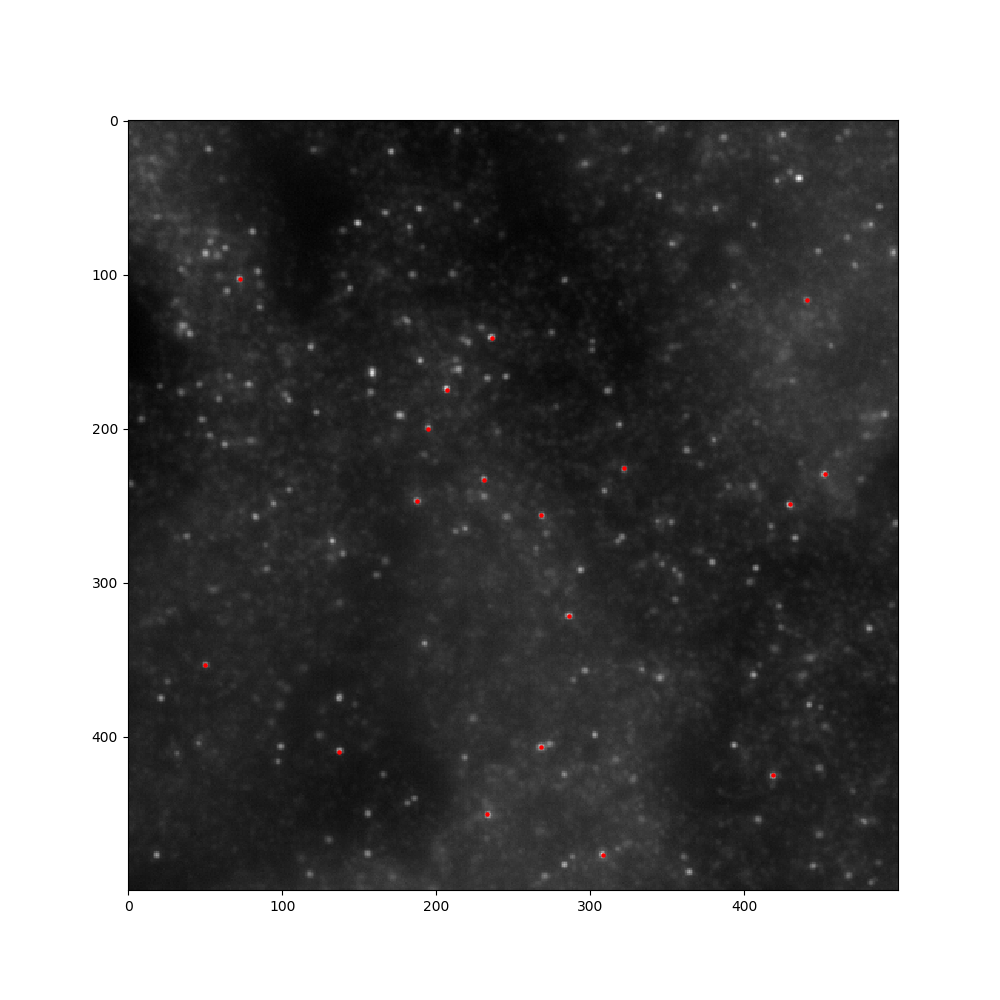

/Users/chris.johnson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


In [16]:
%matplotlib notebook

# Mouse click function to store coordinates
def OnClick(event):
    ix, iy = event.xdata, event.ydata

    # assign global variable to access outside of function
    global coords
    coords.append((int(ix), int(iy)))
    plt.scatter(ix, iy, s=5, c='red', marker='o')

    return

fig = plt.figure(1, figsize = (10,10))
plt.imshow(sample_500, cmap = 'gray')  #
ax = fig.add_subplot(111)

coords = []

# Call click func
cid = fig.canvas.mpl_connect('button_press_event', OnClick)

plt.show()

### Return the coordinates that you clicked on

In [17]:
coords

[(206, 174),
 (136, 410),
 (267, 406),
 (285, 321),
 (187, 247),
 (72, 102),
 (452, 229),
 (429, 248),
 (418, 424),
 (308, 476),
 (49, 353),
 (194, 200),
 (235, 141),
 (440, 116),
 (232, 450),
 (267, 256),
 (230, 233),
 (321, 225)]

In [36]:
def GrabThumb(img,coord,radius):
    """
    makes a thumnail from img, centered on coord, with edge width of 2x radius and returns that
    """
    x,y = coord
    x += 1
    y -= 1
    thumb = img[y-radius:y+radius,x-radius:x+radius]
    return thumb

In [37]:
%matplotlib inline

In [40]:
thumb1 = GrabThumb(sample_500,coords[1],5)

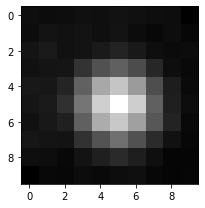

In [41]:
# Make sure I'm grabbing spots correctly
plt.figure(figsize = (3,3))
plt.imshow(thumb1, cmap = 'gray')
plt.tight_layout()
plt.show()

# Look at the spots identified
*Note* this section assumes you grabbed 16 spots

In [ ]:
thumb_stack = np.zeros([16,10,10])

In [44]:
for i in range(16):
    thumb = GrabThumb(sample_500,coords[i],5)
    thumb_stack[i,:,:] = thumb

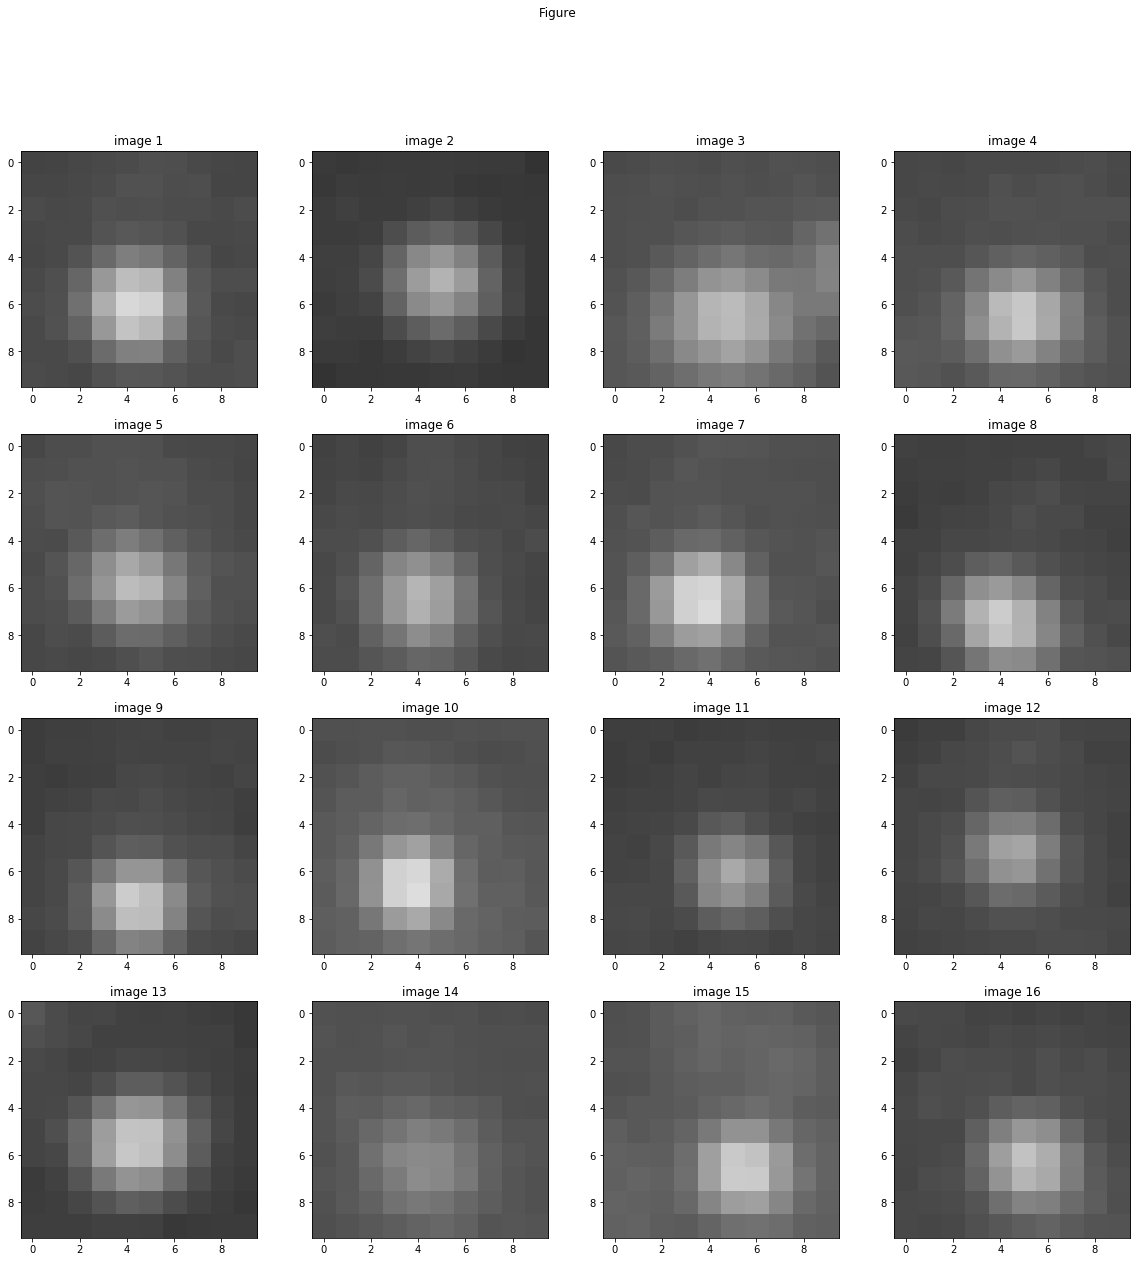

In [46]:
mg.PlotAsPanels(thumb_stack, axis = 1, dims = [4,4], scale = [0,15000])

# Adjust locations of spots at pixel level.  (Y,X) format

In [47]:
corrections = [(-2,0),
               (-1,0),
               (-2,0),
               (-2,0),
               (-1,0),
               (-2,0),
               (-2,1),
               (-3,1),
               (-3,0),
               (-2,1),
               (-2,0),
               (-1,0),
               (-1,0),
               (-2,0),
               (-2,-1),
               (-2,-1)
              ]

In [66]:
corrected_coords = []
for i in range(0,16):
    corr_x = coords[i][0] - corrections[i][1]
    corr_y = coords[i][1] - corrections[i][0]
    corrected_coords.append((corr_x,corr_y))

In [67]:
for i in range(16):
    thumb = GrabThumb(sample_500,corrected_coords[i],5)
    thumb_stack[i,:,:] = thumb

In [322]:
p_list = []
for i in range(1,17):
    name = 'spot '+str(i)
    p_list.append(name)

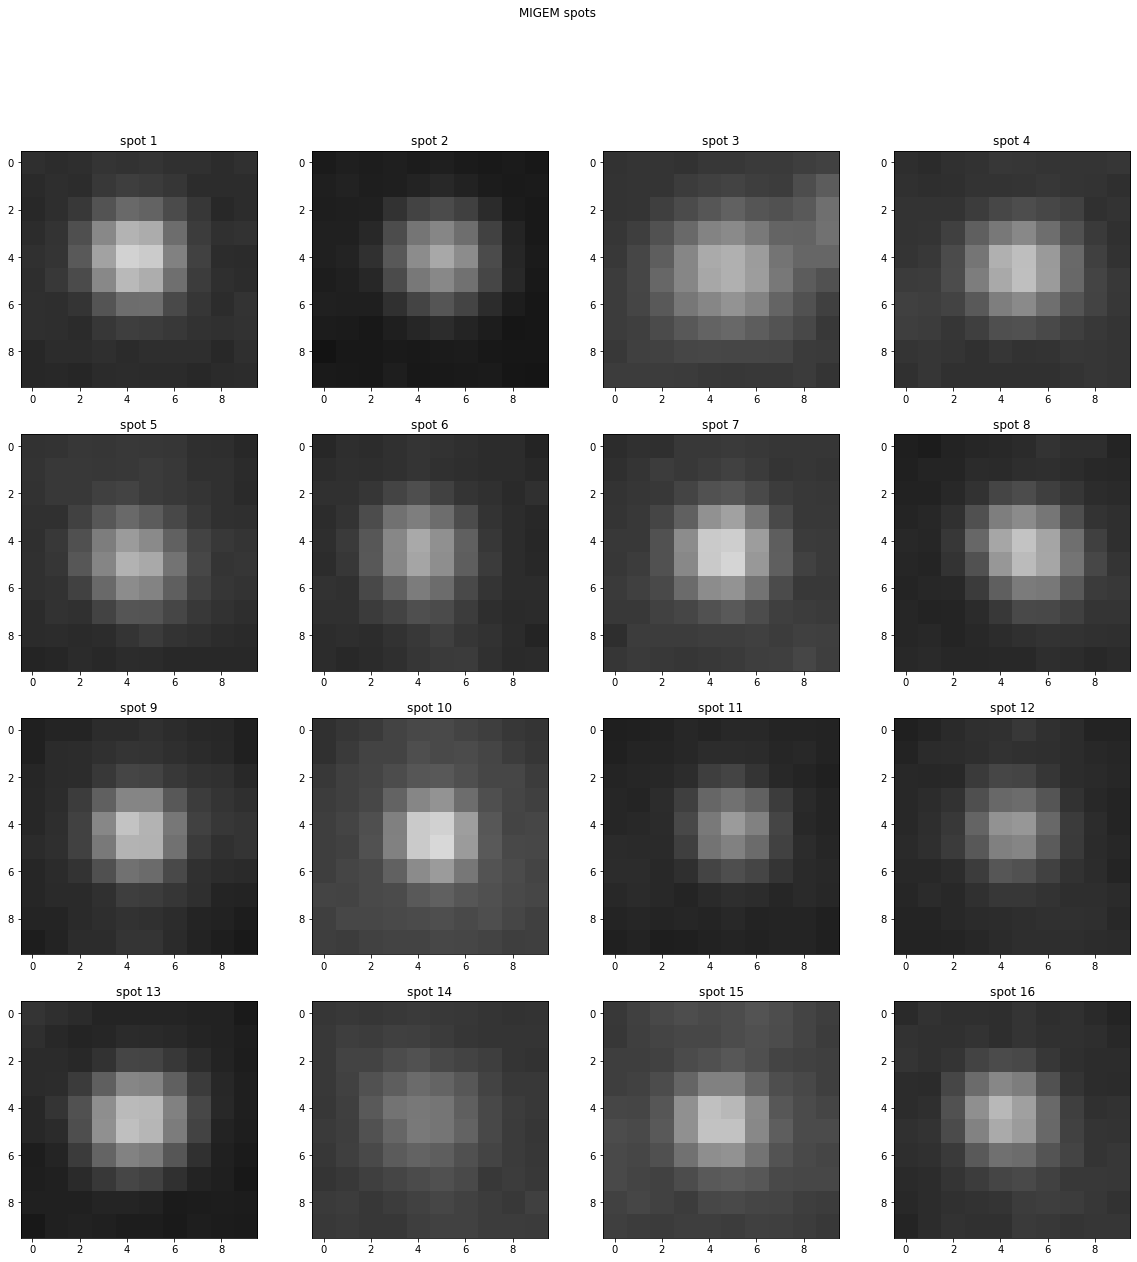

In [324]:
mg.PlotAsPanels(thumb_stack, axis = 1, dims = [4,4], scale = [2000,15000],
                title = 'MIGEM spots', panel_list = p_list, save = True)

# Take the average pixel values of the thumbnails as a template

In [71]:
thumb_x = np.mean(thumb_stack,axis = 0)

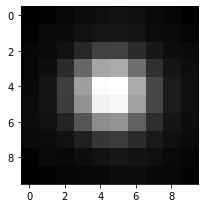

In [325]:
plt.figure(figsize = (3,3))
plt.imshow(thumb_x, cmap = 'gray')
plt.tight_layout()
plt.savefig('MIGEM spot')
plt.show()

# OK, you can start running the notebook again (if you skipped over that)
## Here's where we import the template spot that was developed. It has been trimmed
We found that a smaller spot works best

In [27]:
thumb = mg.single_spot

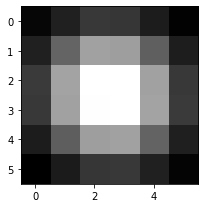

In [28]:
plt.figure(figsize = (3,3))
plt.imshow(thumb, cmap = 'gray')
plt.tight_layout()

### Align the spot to the image

In [29]:
from skimage.feature import match_template

In [30]:
# Here is the command that does the thing
result = match_template(sample_500, thumb, pad_input = True)

# Look for pieces of the image that match the template
high signal intensity = areas that match well to the input template

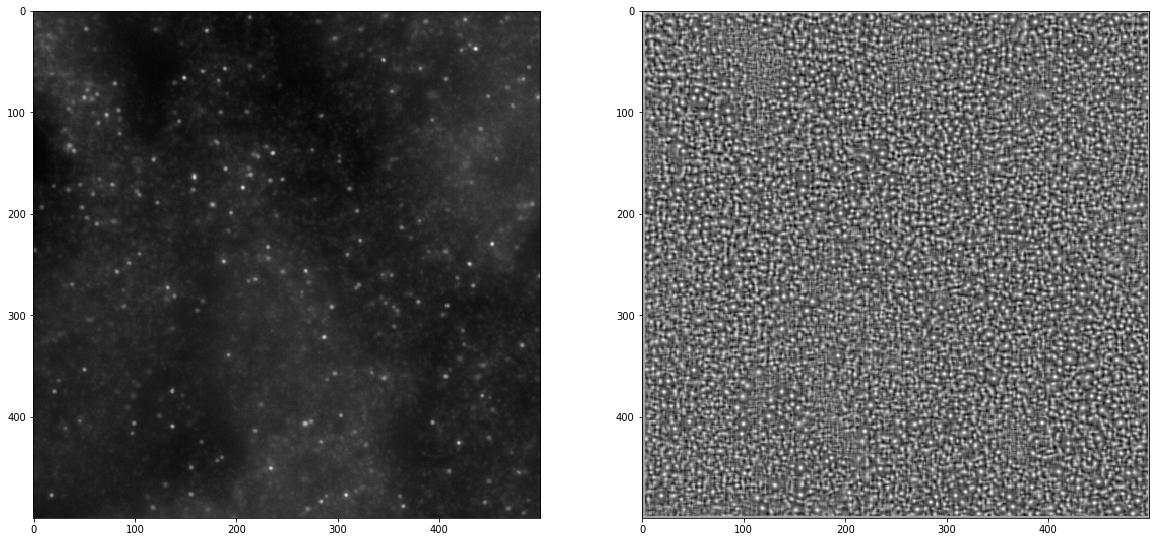

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
axes[0].imshow(sample_500, cmap = 'gray')
axes[1].imshow(result)
plt.show()

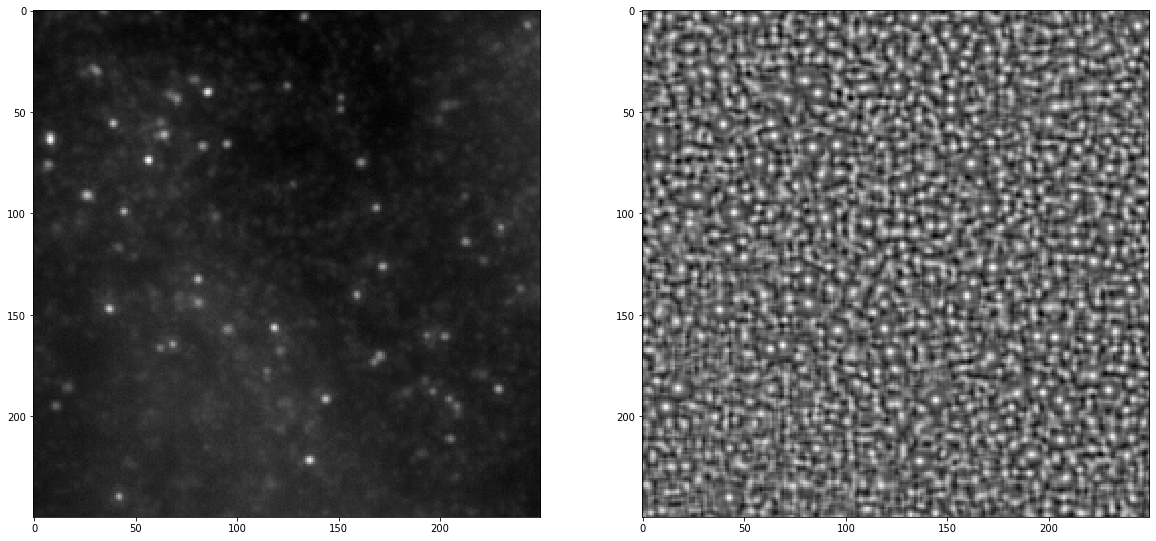

In [32]:
# Zoom in
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
axes[0].imshow(sample_500[100:350,150:400], cmap = 'gray')
axes[1].imshow(result[100:350,150:400])
plt.show()

Looks like it can identify spots of varying intensity on backgrounds of varying intesity.
Local maxima will identify too many things

# Identify individual spots from the probability output
A thresholding approach works well and is easy to adjust quickly to change the number of spots recovered

In [33]:
# Try a thresholding approach
result_threshold_70 = np.where(result > .7, 1, 0)
result_threshold_80 = np.where(result > .8, 1, 0)
result_threshold_85 = np.where(result > .85, 1, 0)
result_threshold_90 = np.where(result > .9, 1, 0)

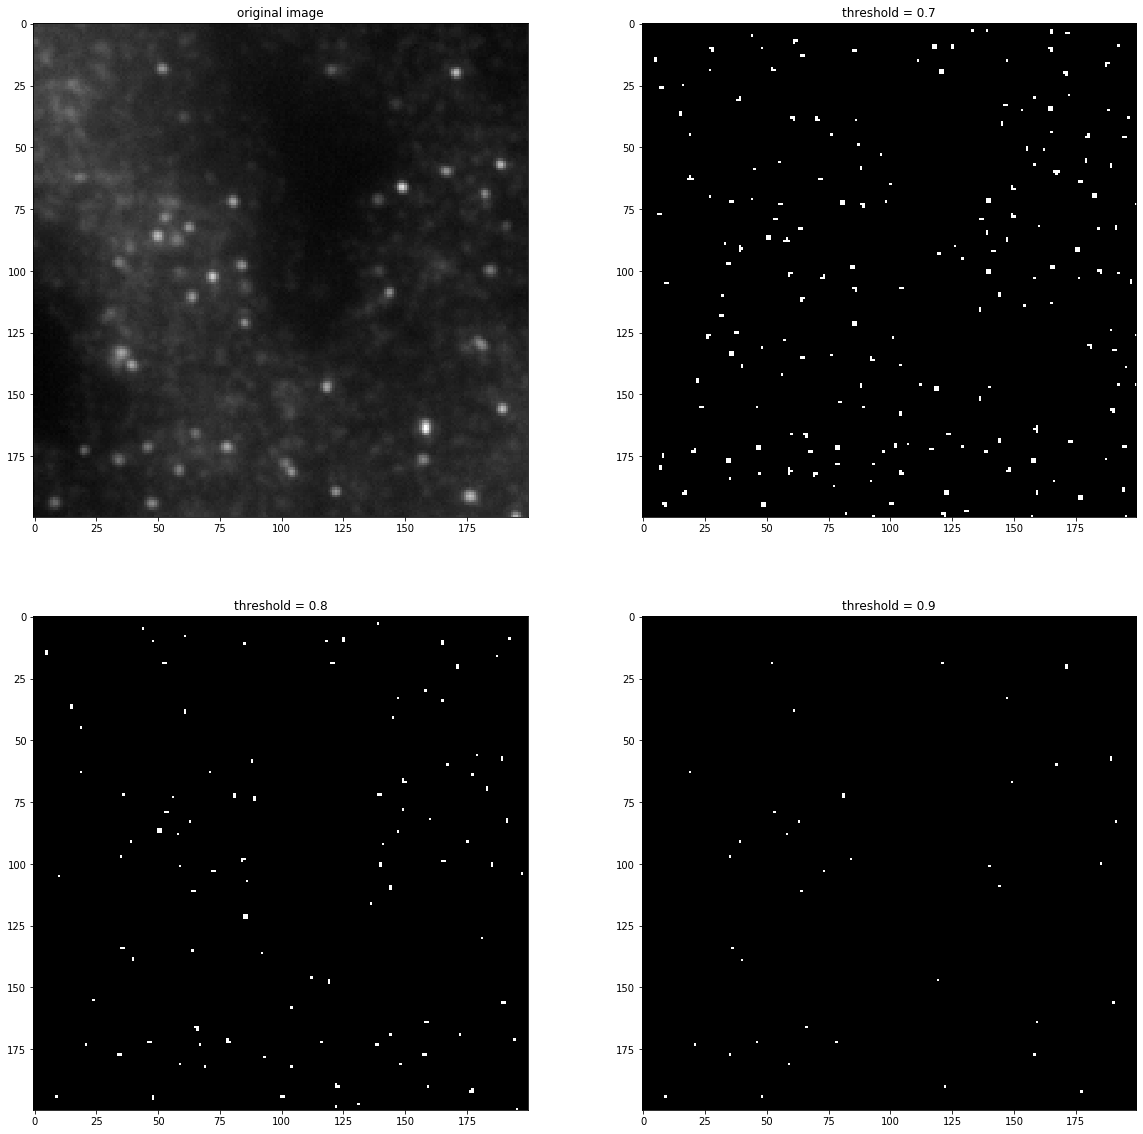

In [34]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
axes[0,0].imshow(sample_500[0:200,0:200], cmap = 'gray')
axes[0,1].imshow(result_threshold_70[0:200,0:200])
axes[1,0].imshow(result_threshold_80[0:200,0:200])
axes[1,1].imshow(result_threshold_90[0:200,0:200])
axes[0,0].title.set_text('original image')
axes[0,1].title.set_text('threshold = 0.7')
axes[1,0].title.set_text('threshold = 0.8')
axes[1,1].title.set_text('threshold = 0.9')
plt.show()

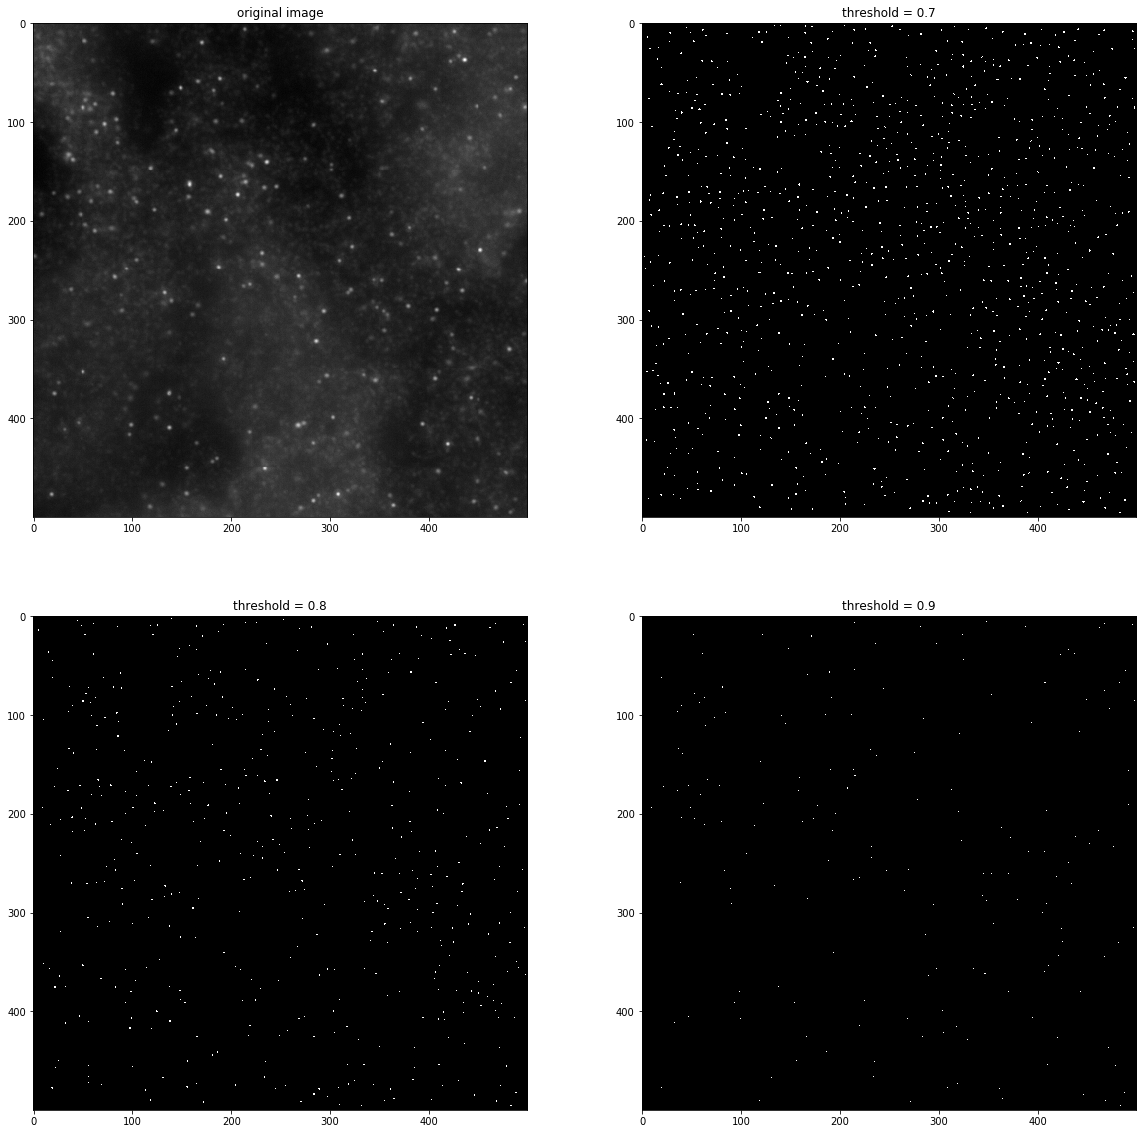

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
axes[0,0].imshow(sample_500, cmap = 'gray')
axes[0,1].imshow(result_threshold_70)
axes[1,0].imshow(result_threshold_80)
axes[1,1].imshow(result_threshold_90)
axes[0,0].title.set_text('original image')
axes[0,1].title.set_text('threshold = 0.7')
axes[1,0].title.set_text('threshold = 0.8')
axes[1,1].title.set_text('threshold = 0.9')
plt.show()

# Convert the spots to centroids (then stamp a spot over them to visualize)

In [36]:
import scipy.ndimage as ndi

In [37]:
# Label individual spots
spot_count,num = ndi.label(result_threshold_90)

In [38]:
# Create a stamping template
template = np.array([[0,0,1,1,0,0],
                    [0,1,1,1,1,0],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [0,1,1,1,1,0],
                    [0,0,1,1,0,0]], dtype = bool)

In [39]:
def StampSpot(image, coord, template):
    """
    adds a boolean template to an image centered on the desired coordinates
    needs the image and coordiantes. Will accept an np array to replace default template as kwarg
    """
    
    y,x = coord
    y_off,x_off = template.shape
    y_start = int(y-0.5*y_off)
    x_start = int(x-0.5*x_off)
    for i in range(y_off):
        for n in range(x_off):
            image[y_start+i,x_start+n] = template[i,n]
    return image

In [40]:
# Get centroids of each spot
COMs = ndi.measurements.center_of_mass(sample_500,spot_count,range(num))

In [41]:
# Stamp template over centroids of spots on a mask
stamped_spots = np.zeros_like(sample_500).astype(bool)

for point in COMs:
    stamped_spots = StampSpot(stamped_spots,point,template)

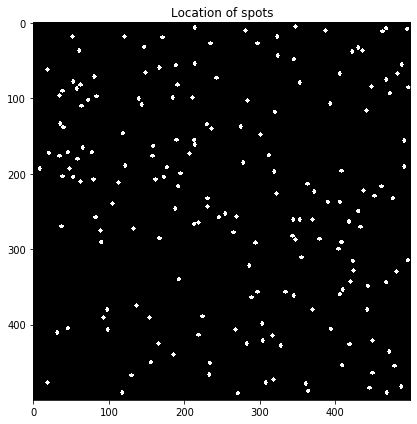

In [42]:
plt.figure(figsize = (6,6))
plt.imshow(stamped_spots, cmap = 'gray')
plt.title('Location of spots')
plt.tight_layout()
plt.show()

### Compare the identified spots at that threshold to the original image

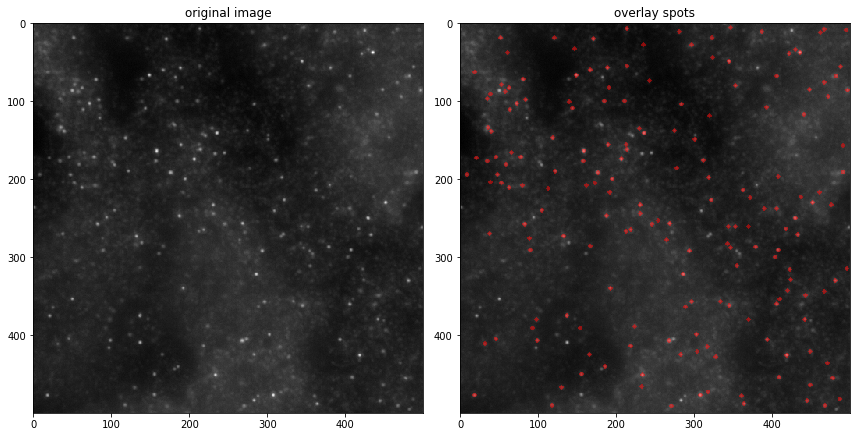

183  spots


In [43]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axes[0].imshow(sample_500, cmap = 'gray')
axes[1].imshow(sample_500, cmap = 'gray')
axes[1].imshow(np.ma.array(stamped_spots, mask = stamped_spots==0), 
               cmap = 'flag', alpha = 0.5)
axes[0].title.set_text('original image')
axes[1].title.set_text('overlay spots')
plt.tight_layout()
plt.show()
print (num,' spots')

It misses things that are close together. I think this interrupts the template.

# execute over a full image

In [44]:
result_full = match_template(sample_img, thumb, pad_input = True)
result_full_threshold_90 = np.where(result_full > .9, 1, 0)

In [45]:
spot_count,num = ndi.label(result_full_threshold_90)
COMs = ndi.measurements.center_of_mass(sample_img,spot_count,range(num))

stamped_spots_full = np.zeros_like(sample_img).astype(bool)
for point in COMs:
    stamped_spots_full = StampSpot(stamped_spots_full,point,template)

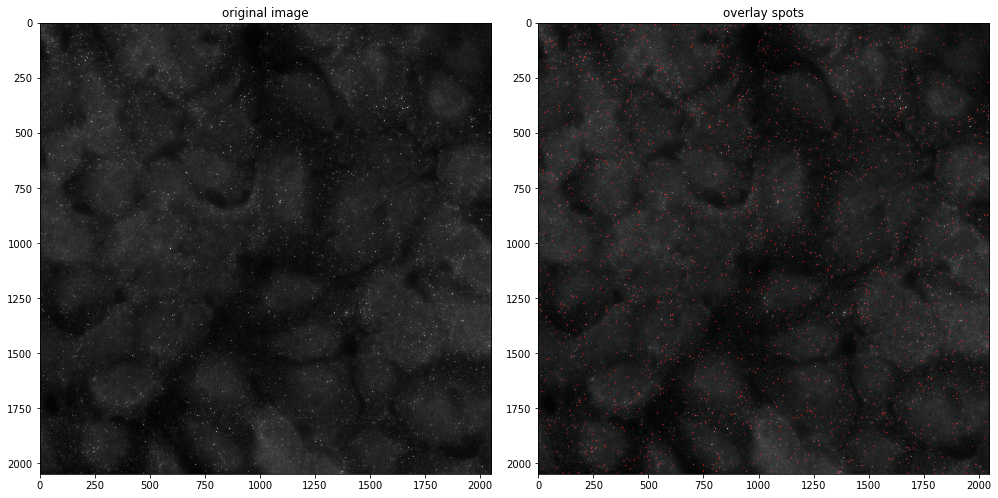

2536  spots


In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))
axes[0].imshow(sample_img, cmap = 'gray')
axes[1].imshow(sample_img, cmap = 'gray')
axes[1].imshow(np.ma.array(stamped_spots_full, mask = stamped_spots_full==0), 
               cmap = 'flag', alpha = 0.5)
axes[0].title.set_text('original image')
axes[1].title.set_text('overlay spots')
plt.tight_layout()
plt.show()
print (num,' spots')

OK, so maybe some work to do with sensitivity. I like big template best and trying additional 2-spot templates as additional layers.
For now lets see how it does on other images from the set.

## Execute on another image
Is the spot template generalizable in a different fluorescent channel?

In [47]:
scratch_img = np.load(image_path+'sample_MIGEM_img2.npy')

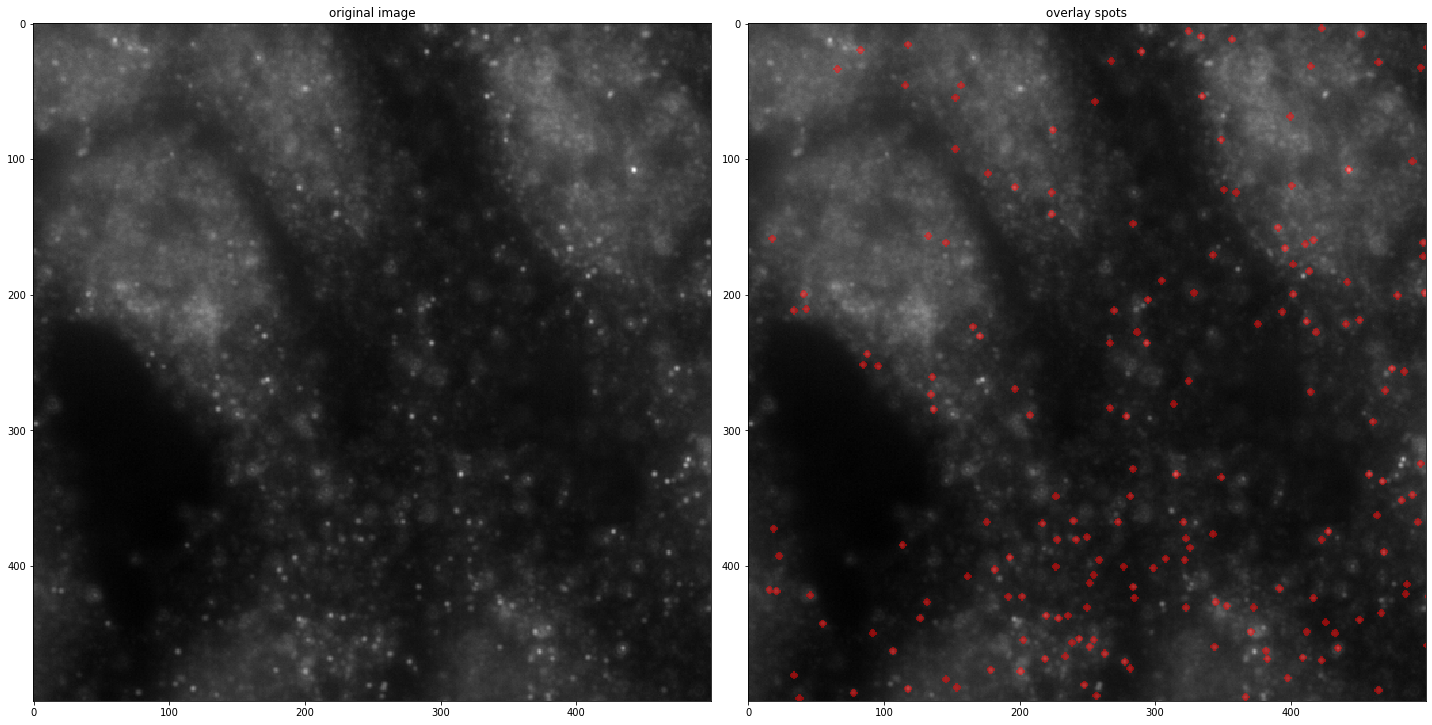

3034 spots


In [48]:
result_full = match_template(scratch_img, thumb, pad_input = True)
result_full_threshold_90 = np.where(result_full > .9, 1, 0)

spot_count,num = ndi.label(result_full_threshold_90)
COMs = ndi.measurements.center_of_mass(scratch_img,spot_count,range(num))

stamped_spots_full = np.zeros_like(sample_img).astype(bool)
for point in COMs:
    stamped_spots_full = StampSpot(stamped_spots_full,point,template)
    
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
axes[0].imshow(scratch_img[0:500,0:500], cmap = 'gray')
axes[1].imshow(scratch_img[0:500,0:500], cmap = 'gray')
axes[1].imshow(np.ma.array(stamped_spots_full, mask = stamped_spots_full==0)[0:500,0:500], 
               cmap = 'flag', alpha = 0.5)
axes[0].title.set_text('original image')
axes[1].title.set_text('overlay spots')
plt.tight_layout()
plt.show()
print (num, 'spots')

## Execute on a third sample.
This will look a lot like the previous images. It's the same cells, but a different fluorescent channel. We see the cells due to background fluorescence, but note that the spots have moved.

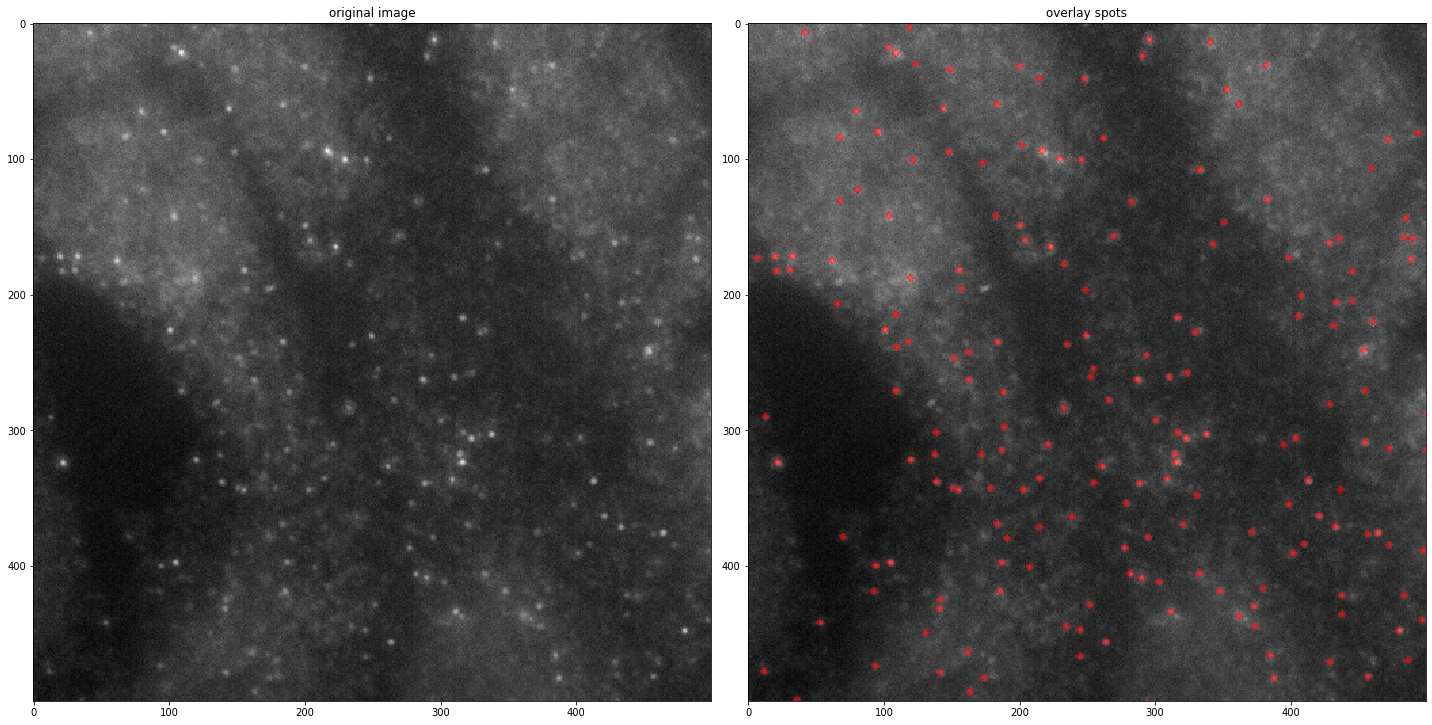

2752 spots


In [49]:
scratch_img = np.load(image_path+'sample_MIGEM_img3.npy')
result_full = match_template(scratch_img, thumb, pad_input = True)
result_full_threshold_90 = np.where(result_full > .77, 1, 0)

spot_count,num = ndi.label(result_full_threshold_90)
COMs = ndi.measurements.center_of_mass(scratch_img,spot_count,range(num))

stamped_spots_full = np.zeros_like(sample_img).astype(bool)
for point in COMs:
    stamped_spots_full = StampSpot(stamped_spots_full,point,template)
    
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
axes[0].imshow(scratch_img[0:500,0:500], cmap = 'gray')
axes[1].imshow(scratch_img[0:500,0:500], cmap = 'gray')
axes[1].imshow(np.ma.array(stamped_spots_full, mask = stamped_spots_full==0)[0:500,0:500],
               cmap = 'flag', alpha = 0.5)
axes[0].title.set_text('original image')
axes[1].title.set_text('overlay spots')
plt.tight_layout()
plt.show()
print (num, 'spots')

## All in all this works pretty well.
It outperformed several other approahces including routines used for detecting stars from astronomical images and a rudimentary deep-learning algorithm that was fed similar hand-identified input spot information. A real advantage of this approach is that it operates very quickly; somehting that would have been key if we had deployed MIGEM (which would have needed up to 24 images per well to capture sufficient information for complex gene expression analysis)

**Note** the location of the spots is captured in the list of tuples COMs

In [50]:
COMs[:10]

[(987.2092103924122, 1012.1953941427229),
 (3.480895352152837, 119.0),
 (3.0, 1091.0),
 (3.0, 1340.0),
 (3.0, 1830.0),
 (4.0, 522.4958891595616),
 (4.0, 626.0),
 (5.0, 534.0),
 (7.4931540643888, 42.0),
 (7.0, 580.0)]